<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Oscar Flores
    
**Fecha:** 4 de Mayo de 2021

**Expediente** : 715029
**Profesor:** Oscar David Jaramillo Zuluaga.

**Link Github:** https://github.com/OscarFlores-IFi/SPF-2021-Tareas

# Tarea 10: Clase 24
  

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta, date
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

# Calculation of mean and std of log-returns
def calc_daily_ret(closes):
    ret = np.log(closes/closes.shift(1)).dropna()
    return ret.mean(), ret.std()



### Descarga de datos

In [3]:
asset = 'MSFT'
# asset = 'ZC=F'

closes = get_adj_closes([asset], '2017-01-01')
closes_msft = closes.loc[:,asset]
closes_msft

Date
2017-01-03     58.538
2017-01-04     58.276
2017-01-05     58.276
2017-01-06     58.782
2017-01-09     58.595
               ...   
2021-05-03    251.860
2021-05-04    247.790
2021-05-05    246.470
2021-05-06    249.730
2021-05-07    252.620
Name: MSFT, Length: 1094, dtype: float64

S0 = 252.6199951171875


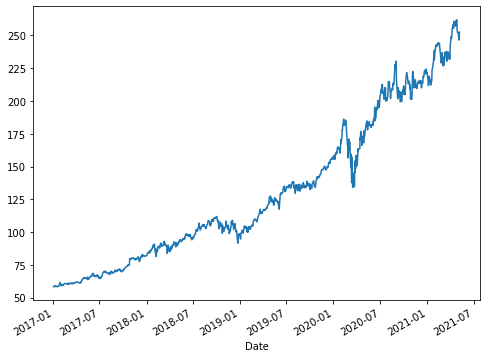

In [4]:
closes_msft.plot(figsize=(8,6));
print('S0 = {}'.format(closes_msft[-1]))

### Definición de variables

In [5]:
mu, sigma = calc_daily_ret(closes_msft)
expiry = '2021-09-17'
# k = 740
k = 290
S = closes_msft.iloc[-1]
r = 0.006/360

mu, sigma, r

(0.0013377887561902531, 0.017973443953724327, 1.6666666666666667e-05)

### Precio opción europea

In [27]:
# Calculation of the price of a call and a put
def opcion_europea(S0, k, mu, sigma, expiry, nscen = 10000, plot=False):
    def int_confianza(mu, sigma, confidence): 
        return st.norm.interval(confidence, loc=mu, scale=sigma)
    
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiry, freq='B')
    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+mu,index=dates)
#     sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates) # No funciona!! tasa de crecimiento mu, no r.
#                                                                                r solamente se utiliza para traer flujos a valor presente
    sim_closes = S0*np.exp(sim_ret.cumsum())

    if plot:
        np.fmax(sim_closes,k).plot(legend = False)
        plt.title('Call europea')
        
        np.fmin(sim_closes,k).plot(legend = False)
        plt.title('Put europeo')
    
    else:
        call=pd.DataFrame({'Call':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0).mean(axis=1)}, index=dates)
        ax = call.plot();

        put=pd.DataFrame({'Put':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0).mean(axis=1)}, index=dates)
        put.plot(ax = ax);

        conf = 0.95
        print('Call: {}'.format(call.iloc[-1].Call))
        print('Confidence interval (95%): {}{}'.format(int_confianza(call.iloc[-1], sim_closes.iloc[-1].sem(), conf)[0],
             int_confianza(call.iloc[-1], sim_closes.iloc[-1].sem(), conf)[1]))
        print('Put: {}'.format(put.iloc[-1].Put))
        print('Confidence interval (95%): {}{}'.format(int_confianza(put.iloc[-1], sim_closes.iloc[-1].sem(), conf)[0],
             int_confianza(put.iloc[-1], sim_closes.iloc[-1].sem(), conf)[1]))    
    

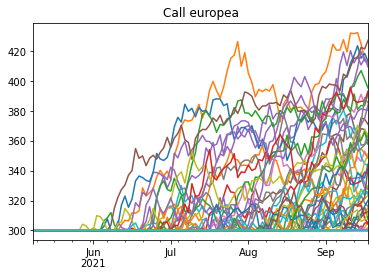

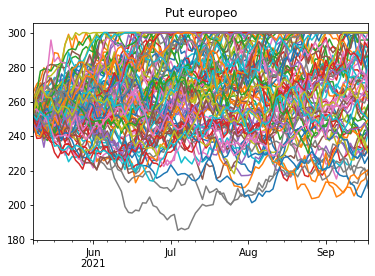

In [28]:
opcion_europea(S, k, mu, sigma, expiry, nscen=100, plot=True)

Call: 17.521379357716807
Confidence interval (95%): [16.49161633][18.55114238]
Put: 24.933474032284153
Confidence interval (95%): [23.90371101][25.96323706]


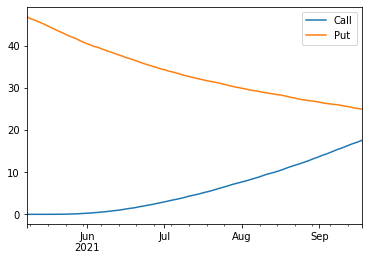

In [29]:
opcion_europea(S, k, mu, sigma, expiry)

### Precio de la opción con Black-Scholes

(Call    13.055
 Name: 2021-09-17 00:00:00, dtype: float64,
 Put    24.278
 Name: 2021-09-17 00:00:00, dtype: float64)

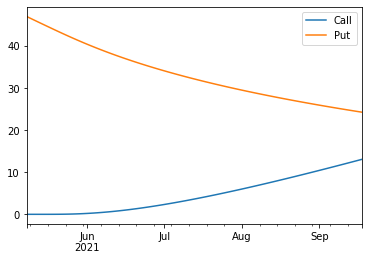

In [30]:
# Analytical calculation of the price of a call and a put through Black-Scholes. 
def Black_Scholes(S0, k, mu, sigma, expiry):
    norm = lambda x:st.norm(0, 1 ).cdf(x)
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiry, freq='B')
    ndays = len(dates)
    
    def d1(t):
        return (np.log(S0/k) + (mu + (sigma**2)/2)*t)/(sigma*t**0.5)
    
    def d2(t):
        return (np.log(S0/k) + (mu - (sigma**2)/2)*t)/(sigma*t**0.5)
    
    def put(S0, k, mu, sigma, t):
        return k*np.exp(-mu * t) * norm(-d2(t)) - S0*norm(-d1(t))
    
    def call(S0, k, mu, sigma, t):
        return S0*norm(d1(t)) - k*np.exp(-mu * t) * norm(d2(t))

    Call = pd.DataFrame({'Call':[call(S0, k, mu, sigma, t) for t in np.arange(ndays)+1]},index=dates)
    Put = pd.DataFrame({'Put':[put(S0, k, mu, sigma, t) for t in np.arange(ndays)+1]},index=dates)   
    
    ax = Call.plot()
    Put.plot(ax = ax)
    
    return Call.iloc[-1], Put.iloc[-1]

Black_Scholes(S, k, mu, sigma, expiry)


## Precio de opciones Barrera

In [31]:
# Definir barrera
def opciones_barrera(S, k, mu, sigma, expiry, bu = 0, bd = 0, n_sim = 10000):
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')

    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+mu,index=dates)
    sim_closes = S*np.exp(sim_ret.cumsum())
    
    # Calcular la prima de una opción Europea
    call = pd.DataFrame({'Call':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                         .mean(axis=1)},index=dates)
    put = pd.DataFrame({'Put':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0)
                     .mean(axis=1)},index=dates)

    # CALL OPTIONS
    ax = call.plot();
    
    I = (sim_closes > bu).cumsum(axis=0) > 0
    callui = pd.DataFrame({'Call up-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                           .mean(axis=1)},index=dates)
    callui.plot(ax=ax);

    I = (sim_closes > bu).cumsum(axis=0) == 0
    calluo = pd.DataFrame({'Call up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)
    calluo.plot(ax=ax);

    I = (sim_closes < bd).cumsum(axis=0) > 0
    calldi = pd.DataFrame({'Call down-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)    
    calldi.plot(ax=ax);
    
    I = (sim_closes < bd).cumsum(axis=0) == 0
    calldo = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)
    calldo.plot(ax=ax);
    
    
    # PUT OPTIONS 
    ax = put.plot();

    I = (sim_closes > bu).cumsum(axis=0) > 0
    putui = pd.DataFrame({'Put up-and-in':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                           .mean(axis=1)},index=dates)
    putui.plot(ax=ax);

    I = (sim_closes > bu).cumsum(axis=0) == 0
    putuo = pd.DataFrame({'Put up-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    putuo.plot(ax=ax);
    
    I = (sim_closes < bd).cumsum(axis=0) > 0
    putdi = pd.DataFrame({'Put down-and-in':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)    
    putdi.plot(ax=ax);
    
    I = (sim_closes < bd).cumsum(axis=0) == 0
    putdo = pd.DataFrame({'Put down-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    putdo.plot(ax=ax);

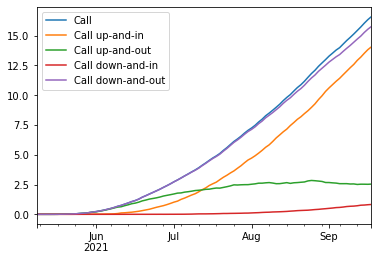

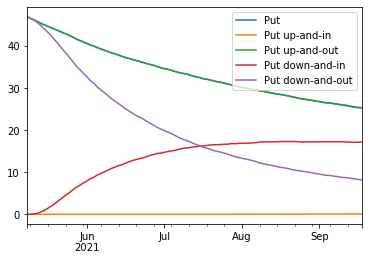

In [32]:
# bu = 750
# bd = 680

bu = 340
bd = 230
opciones_barrera(S, k, mu, sigma, expiry, bu=bu, bd=bd)

### Precio opcion asiática


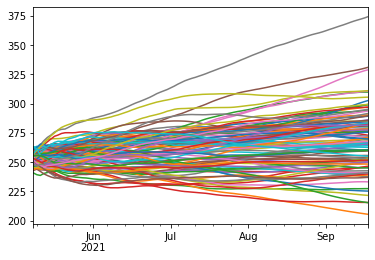

In [33]:
def opcion_asiatica(S, k, mu, sigma, expiry, n_sim = 10000, plot=False):
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')

    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+mu,index=dates)
    sim_closes = S*np.exp(sim_ret.cumsum())

    for_avg = 1/(np.arange(sim_closes.shape[0])+1) #Necesario para calcular el promedio aritmetico a la suma acumulada
    cum_sum = sim_closes.cumsum() #La suma acumulada
    
    asiatica = np.multiply(for_avg,cum_sum.T).T
    

    
    ##### Calculando opción asiática con promedio aritmetico ##### (recordar que también existe la opción asiatica de promedio geometrico)
    calla = pd.DataFrame({'Call asiatico':np.exp(-r*ndays)*np.fmax(asiatica - k, 0)
                         .mean(axis=1)},index=dates)
    puta = pd.DataFrame({'Put asiatico':np.exp(-r*ndays)*np.fmax(k - asiatica, 0)
                     .mean(axis=1)},index=dates)
    
    # Calcular la prima de una opción Europea
    call = pd.DataFrame({'Call':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                         .mean(axis=1)},index=dates)
    put = pd.DataFrame({'Put':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0)
                     .mean(axis=1)},index=dates)    
    
    if plot:
        asiatica.plot(legend=False)
    
    else:
        ax = call.plot()
        calla.plot(ax = ax)

        put.plot(ax = ax)
        puta.plot(ax = ax)
    
    
opcion_asiatica(S, k, mu, sigma, expiry, n_sim = 100,plot=True)

### Simulación escenarios

Valor futuro esperado: 292.53580860019457


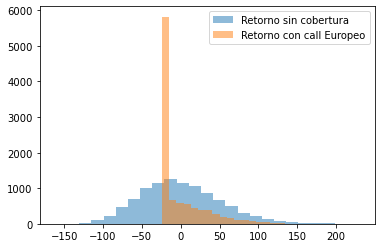

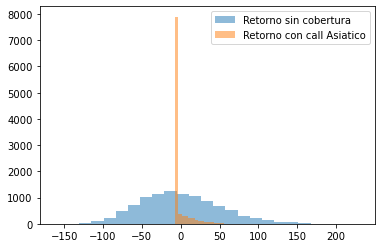

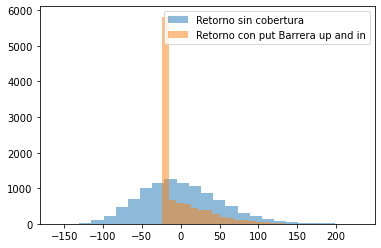

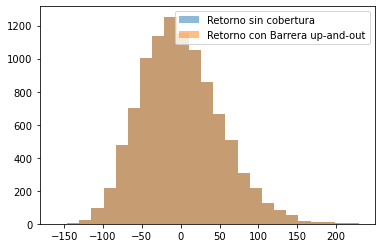

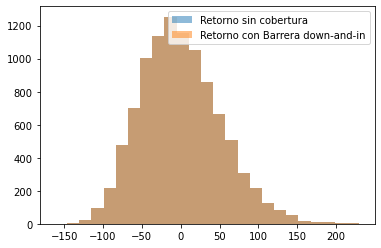

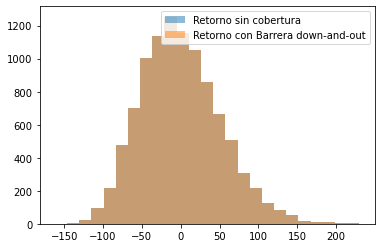

In [42]:
def expected_return_long(S, k, mu, sigma, expiry, bu = 0, bd = 0, n_sim = 10000):
    bins = 25
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')

    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+mu,index=dates)
    sim_closes = pd.DataFrame(S*np.exp(sim_ret.cumsum()))

    ############# Posición Larga #############
    # Las comparaciones de ingreso se harán en base al valor del precio futuro.
    F = sim_closes.mean(axis=1) # Contratando un Futuro a precio 'justo'. 
    return_F = (sim_closes.T-F).T
    print('Valor futuro esperado: {}'.format(F[-1]))

    # cobertura con call europea
    call_price = pd.DataFrame({'Call':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                     .mean(axis=1)},index=dates)
    return_call = (np.fmax(sim_closes,k).T - F - np.exp(r*ndays)*call_price['Call']).T

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5);
    plt.hist(return_call.iloc[-1], label='Retorno con call Europeo', bins=bins, alpha=0.5);
    plt.legend()
    plt.show()
    
    # cobertura con call asiatica
    for_avg = 1/(np.arange(sim_closes.shape[0])+1) #Necesario para calcular el promedio aritmetico a la suma acumulada
    cum_sum = sim_closes.cumsum() #La suma acumulada
    
    asiatica = np.multiply(for_avg,cum_sum.T).T
    
    calla_price = pd.DataFrame({'Call asiatico':np.exp(-r*ndays)*np.fmax(asiatica - k, 0)
                     .mean(axis=1)},index=dates)
    return_calla = (np.fmax(asiatica,k).T - F - np.exp(r*ndays)*calla_price['Call asiatico']).T
        
    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5);
    plt.hist(return_calla.iloc[-1], label='Retorno con call Asiatico', bins=bins, alpha=0.5);
    plt.legend()
    plt.show()

    # Cobertura con barrera up and in 
    I = (sim_closes > bu).cumsum(axis=0) > 0
    callui_price = pd.DataFrame({'Call up-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                           .mean(axis=1)},index=dates)
    return_callui_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*callui_price['Call up-and-in']).T.fillna(0)
    return_callui_n = (sim_closes[~I].T - F - callui_price['Call up-and-in']).T.fillna(0)
    return_callui = return_callui_n + return_callui_p


    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
    plt.hist(return_callui.iloc[-1], label='Retorno con put Barrera up and in', bins = 25, alpha=0.5)
    plt.legend() 
    plt.show()

    # Cobertura con barrera up and out
    I = (sim_closes > bu).cumsum(axis=0) == 0
    calluo_price = pd.DataFrame({'Call up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)
    return_calluo_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calluo_price['Call up-and-out']).T.fillna(0)
    return_calluo_n = (sim_closes[~I].T - F - calluo_price['Call up-and-out']).T.fillna(0)
    return_calluo = return_calluo_n + return_calluo_p

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
    plt.hist(return_calluo.iloc[-1], label='Retorno con Barrera up-and-out', bins = 25, alpha=0.5)
    plt.legend()
    plt.show()
    
    # Cobertura con barrera down and in
    I = (sim_closes < bd).cumsum(axis=0) > 0
    calldi_price = pd.DataFrame({'Call down-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)  
    return_calldi_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calldi_price['Call down-and-in']).T.fillna(0)
    return_calldi_n = (sim_closes[~I].T - F - calldi_price['Call down-and-in']).T.fillna(0)
    return_calldi = return_calldi_n + return_calldi_p

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
    plt.hist(return_calldi.iloc[-1], label='Retorno con Barrera down-and-in', bins = 25, alpha=0.5)
    plt.legend()
    plt.show()
    
    # Cobertura con barrera down and out
    I = (sim_closes < bd).cumsum(axis=0) > 0
    calldo_price = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)  
    return_calldo_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calldo_price['Call down-and-out']).T.fillna(0)
    return_calldo_n = (sim_closes[~I].T - F - calldo_price['Call down-and-out']).T.fillna(0)
    return_calldo = return_calldo_n + return_calldo_p

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
    plt.hist(return_calldo.iloc[-1], label='Retorno con Barrera down-and-out', bins = 25, alpha=0.5)
    plt.legend()
    plt.show()
    

k = 290
expected_return_long(S, k, mu, sigma, expiry);

In [35]:
def expected_return_short(S, k, mu, sigma, expiry, bu = 0, bd = 0, n_sim = 10000):
    ################ INCOMPLETO!!! NO USAR AÚN ##################
    # Falta ajustar todos los modelos a la posición corta
    
    
    bins = 25
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')

    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+mu,index=dates)
    sim_closes = pd.DataFrame(S*np.exp(sim_ret.cumsum()))

    ############# Posición Corta #############
    # Las comparaciones de ingreso se harán en base al valor del precio futuro.
    F = sim_closes.mean(axis=1) # Contratando un Futuro a precio 'justo'. 
    return_F = (F - sim_closes.T).T
    print('Valor futuro esperado: {}'.format(F[-1]))

    # cobertura con put europea
    put_price=pd.DataFrame({'Put':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0).mean(axis=1)}, index=dates)
    return_put = (F - np.fmin(sim_closes,k).T - np.exp(r*ndays)*call_price['Call']).T

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5);
    plt.hist(return_call.iloc[-1], label='Retorno con put Europeo', bins=bins, alpha=0.5);
    plt.legend()
    plt.show()

    
    # cobertura con put asiatica
    for_avg = 1/(np.arange(sim_closes.shape[0])+1) #Necesario para calcular el promedio aritmetico a la suma acumulada
    cum_sum = sim_closes.cumsum() #La suma acumulada

    asiatica = np.multiply(for_avg,cum_sum.T).T

    puta_price = pd.DataFrame({'Put asiatico':np.exp(-r*ndays)*np.fmax(k - asiatica, 0)
                     .mean(axis=1)},index=dates)
    return_puta = (F - np.fmin(asiatica,k).T - np.exp(r*ndays)*np.exp(r*ndays)*puta_price['Put asiatico']).T

    ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5);
    plt.hist(return_puta.iloc[-1], label='Retorno con put Asiatico', bins=bins, alpha=0.5);
    plt.legend()
    plt.show()

#     # Cobertura con barrera up and in 
#     I = (sim_closes > bu).cumsum(axis=0) > 0
#     callui_price = pd.DataFrame({'Call up-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                            .mean(axis=1)},index=dates)
#     return_callui_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*callui_price['Call up-and-in']).T.fillna(0)
#     return_callui_n = (sim_closes[~I].T - F - callui_price['Call up-and-in']).T.fillna(0)
#     return_callui = return_callui_n + return_callui_p


#     ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
#     plt.hist(return_callui.iloc[-1], label='Retorno con put Barrera up and in', bins = 25, alpha=0.5)
#     plt.legend() 
#     plt.show()

#     # Cobertura con barrera up and out
#     I = (sim_closes > bu).cumsum(axis=0) == 0
#     calluo_price = pd.DataFrame({'Call up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                        .mean(axis=1)},index=dates)
#     return_calluo_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calluo_price['Call up-and-out']).T.fillna(0)
#     return_calluo_n = (sim_closes[~I].T - F - calluo_price['Call up-and-out']).T.fillna(0)
#     return_calluo = return_calluo_n + return_calluo_p

#     ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
#     plt.hist(return_calluo.iloc[-1], label='Retorno con Barrera up-and-out', bins = 25, alpha=0.5)
#     plt.legend()
#     plt.show()
    
#     # Cobertura con barrera down and in
#     I = (sim_closes < bd).cumsum(axis=0) > 0
#     calldi_price = pd.DataFrame({'Call down-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                        .mean(axis=1)},index=dates)  
#     return_calldi_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calldi_price['Call down-and-in']).T.fillna(0)
#     return_calldi_n = (sim_closes[~I].T - F - calldi_price['Call down-and-in']).T.fillna(0)
#     return_calldi = return_calldi_n + return_calldi_p

#     ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
#     plt.hist(return_calldi.iloc[-1], label='Retorno con Barrera down-and-in', bins = 25, alpha=0.5)
#     plt.legend()
#     plt.show()
    
#     # Cobertura con barrera down and out
#     I = (sim_closes < bd).cumsum(axis=0) > 0
#     calldo_price = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                        .mean(axis=1)},index=dates)  
#     return_calldo_p = (np.fmax(sim_closes,k)[I].T - F - np.exp(r*ndays)*calldo_price['Call down-and-out']).T.fillna(0)
#     return_calldo_n = (sim_closes[~I].T - F - calldo_price['Call down-and-out']).T.fillna(0)
#     return_calldo = return_calldo_n + return_calldo_p

#     ax = plt.hist(return_F.iloc[-1], label='Retorno sin cobertura', bins=bins, alpha=0.5)
#     plt.hist(return_calldo.iloc[-1], label='Retorno con Barrera down-and-out', bins = 25, alpha=0.5)
#     plt.legend()
#     plt.show()
